# Import

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

# Data + Model

In [ ]:
# Data preprocessing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
image_shape = x_train.shape[1:] if len(x_train.shape)==4 else x_train.shape[1:] +(1,) # Add one channel if there is only 3 to have shape(N_img,pix,pix,n_channel)
x_train = np.reshape(x_train, (-1,)+image_shape).astype('float32')
x_test = np.reshape(x_test, (-1,)+image_shape).astype('float32')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
# Training parameters
batch_size = 128
epochs = 10

In [ ]:
# Model trained without adversity
# named model1

input = tf.keras.Input(shape=image_shape)

x = tf.keras.layers.Conv2D(32,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(32,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dense(64,activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

output = tf.keras.layers.Dense(10,activation = 'softmax')(x)

model1 = tf.keras.Model(inputs=input, outputs=output)

model1.summary()

model1.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics='accuracy')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                             

In [ ]:
#K.set_value(model1.optimizer.learning_rate, 0.001)

In [ ]:
# Fit the model
history = model1.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/10
391/391 [==============================] - 11s 6ms/step - loss: 1.5922 - accuracy: 0.4328 - val_loss: 1.4629 - val_accuracy: 0.4935
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 1.2543 - accuracy: 0.5640 - val_loss: 1.2406 - val_accuracy: 0.5603
Epoch 3/10
391/391 [==============================] - 2s 5ms/step - loss: 1.1175 - accuracy: 0.6165 - val_loss: 1.0996 - val_accuracy: 0.6288
Epoch 4/10
391/391 [==============================] - 2s 5ms/step - loss: 1.0279 - accuracy: 0.6520 - val_loss: 1.0207 - val_accuracy: 0.6536
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 0.9609 - accuracy: 0.6771 - val_loss: 1.0395 - val_accuracy: 0.6452
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 0.9121 - accuracy: 0.6950 - val_loss: 0.9604 - val_accuracy: 0.6820
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 0.8673 - accuracy: 0.7129 - val_loss: 0.9704 - val_accuracy: 0.6811
Epoch

In [ ]:
model1.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9893 - accuracy: 0.6840


[0.9893439412117004, 0.6840000152587891]

Text(0.5, 1.0, 'Original : cat - Prediction : cat - Confidence : 53.07%')

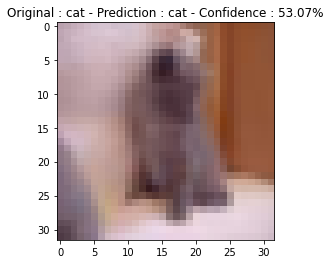

In [ ]:
# Test the network on a random image
n = np.random.randint(len(x_test)) # Image index to be tested
label = classes[np.argmax(y_test[n])]

x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]

plt.imshow(x_test[n])
plt.title('Original : {} - Prediction : {} - Confidence : {:.2f}%'.format(label, label_pred,confidence*100))

# NES attack

In [ ]:
# NES Gradient Estimate
def nes(model,x,y,n_samples,sigma,N=32):
  label = np.argmax(y)
  g = np.zeros((1,N,N,3))
  for i in range(n_samples):
    u = np.random.randn(1,N,N,3)
    g = g + model(x + sigma*u)[0,label]*u
    g = g - model(x - sigma*u)[0,label]*u
  return 1/(2*sigma*n_samples)*g 

In [ ]:
# PGD NES attack

def PGD_blackbox(model,input_image, input_label, epsilon, alpha, nb_iter, verbose = False):
  # Start with a random perturbation :
  tf_image = input_image + (np.random.rand(1,32,32,3)*2-1)*epsilon
  for i in range(nb_iter):
    gradient = nes(model,tf_image,input_label,n_samples,sigma,N=32)
    signed_grad = tf.sign(gradient)
    tf_image = tf_image - alpha * signed_grad
    tf_image = tf.clip_by_value(tf_image, input_image-epsilon, input_image+epsilon)
  return tf_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


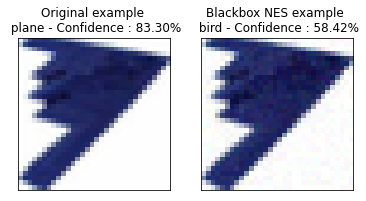

In [ ]:
# Attack parameters
sigma = 0.001
n_samples = 40
epsilon = 8/255
alpha = 0.01
nb_iter = 40



fig, (ax1, ax2) = plt.subplots(1, 2)

# True image
#n = np.random.randint(len(x_test)) # Image index to be attacked

label = classes[np.argmax(y_test[n])]
x_pred = np.reshape(x_test[n],(1,)+image_shape)
y_pred = model1.predict(x_pred)
confidence = np.max(y_pred)
label_pred = classes[np.argmax(y_pred)]


ax1.imshow(x_test[n])
ax1.set_title('Original example \n {} - Confidence : {:.2f}%'.format(label_pred,confidence*100))
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticklabels([])
ax1.set_yticks([])




# Create adverserial example


x_pred_adversarial = PGD_blackbox(model1,tf.constant(x_pred), np.reshape(y_test[n],(-1,10)), epsilon, alpha, nb_iter)

y_pred_adversarial = model1.predict(x_pred_adversarial)
confidence_adversarial = np.max(y_pred_adversarial)
label_pred_adversarial = classes[np.argmax(y_pred_adversarial)]

x_pred_adversarial = np.reshape(x_pred_adversarial,(image_shape))
ax2.imshow(x_pred_adversarial)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_title('Blackbox NES example \n {} - Confidence : {:.2f}%'.format(label_pred_adversarial,confidence_adversarial*100))

fig.savefig('nes',dpi = 300)

# Partial Information Attack

In [ ]:
# NES Gradient Estimate with only partial information
def partial_nes(model,x,y,n_samples,sigma,N=32):
  if y in k_model(model,x,k):
    g = np.zeros((1,N,N,3))
    for i in range(n_samples):
      u = np.random.randn(1,N,N,3)
      g = g + model(x + sigma*u)[0,y]*u
      g = g - model(x - sigma*u)[0,y]*u
    return 1/(2*sigma*n_samples)*g 
  else:
    return 0

In [ ]:
# Return model prediction with partial information
def k_model(model,x,k):
  y = np.reshape(model(x),(-1))
  y_order = np.flip(np.sort(y))[0:k]
  y_list = []
  for i in range(k):
    label = np.where(y==y_order[i])[0][0]
    y_list.append([label,y_order[i]])
  return np.array(y_list)

In [ ]:
# Attack in the partial information setting
def partial_information_attack(k,model,input_image, y_adv,eps_adv,eps_0,delta_eps,eta_max,eta_min):
  cpt = 0
  eps = eps_0
  l_start = [i for i in range(len(y_test)) if np.argmax(y_test[i])==y_adv]
  x_adv = tf.constant(np.reshape(x_test[l_start[np.random.randint(len(l_start))]],(1,32,32,3)))
  x_adv = tf.clip_by_value(x_adv, input_image-eps, input_image+eps)
  while np.argmax(model1(x_adv)) != y_adv:
    x_adv = tf.constant(np.reshape(x_test[l_start[np.random.randint(len(l_start))]],(1,32,32,3)))
    x_adv = tf.clip_by_value(x_adv, input_image-eps, input_image+eps)
  x_adv = tf.clip_by_value(x_adv, input_image-eps, input_image+eps)
  l_x = [x_adv]
  l_conf = [model1(x_adv)[0][y_adv]]
  while eps>eps_adv or np.argmax(model(x_adv)) != y_adv:
    print('confidence :'+str(model1(x_adv)[0][y_adv])+'   eps : '+str(eps))
    g = partial_nes(model,x_adv,y_adv,n_samples,sigma)
    cpt += n_samples
    eta = eta_max
    x_adv_hat = tf.clip_by_value(x_adv + eta*g, input_image-eps, input_image+eps)
    while not(y_adv == k_model(model,x_adv_hat,k)[0,0]):
      if eta < eta_min:
        eps += 2*delta_eps
        delta_eps /= 2
        x_adv_hat = x_adv
        break
      eta /= 2
      x_adv_hat = tf.clip_by_value(x_adv + eta*g, input_image-eps, input_image+eps)
    x_adv = x_adv_hat
    eps -= delta_eps
    l_x.append(x_adv)
    l_conf.append(model1(x_adv)[0][y_adv])
  print(cpt)
  return x_adv,l_x,l_conf

In [ ]:
### Parameters

# Data
n = np.random.randint(len(x_test))
x_natural = tf.constant([x_test[n]]) 
y_adv = 9

# PGD
epsilon = 13/255
alpha = 0.01
nb_iter = 40

# NES
sigma = 0.001
n_samples = 40

# Partial information attack
k = 1
eps_0 = 10*epsilon
delta_eps = 0.01
eta_max = 0.01
eta_min = 0.000000001


### Attack

x_adv,l_x,l_conf = partial_information_attack(k,model1,x_natural, y_adv,epsilon,eps_0,delta_eps,eta_max,eta_min)


fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle('y_adv : '+classes[y_adv])
ax1.imshow(x_test[n])
ax1.set_title(classes[np.argmax(y_test[n])])

ax2.imshow(np.reshape(x_adv,(32,32,3)))
ax2.set_title(classes[np.argmax(model1(x_adv))])

([], <a list of 0 Text major ticklabel objects>)

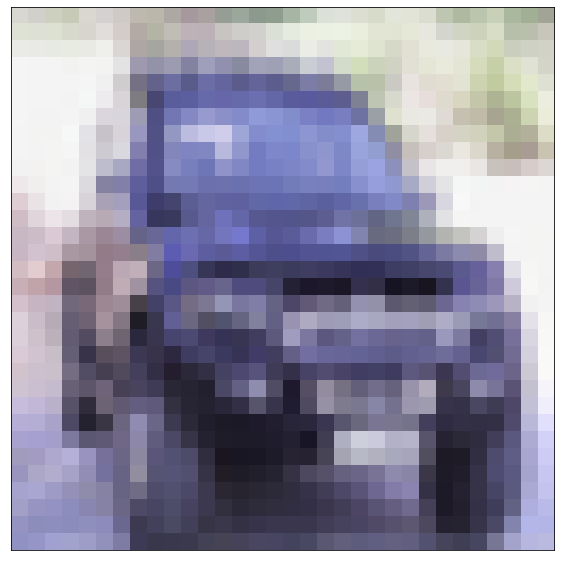

In [ ]:
plt.imshow(x_test[n])
plt.xticks([])
plt.yticks([])

In [ ]:
plt.rcParams['figure.figsize'] = [20,10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


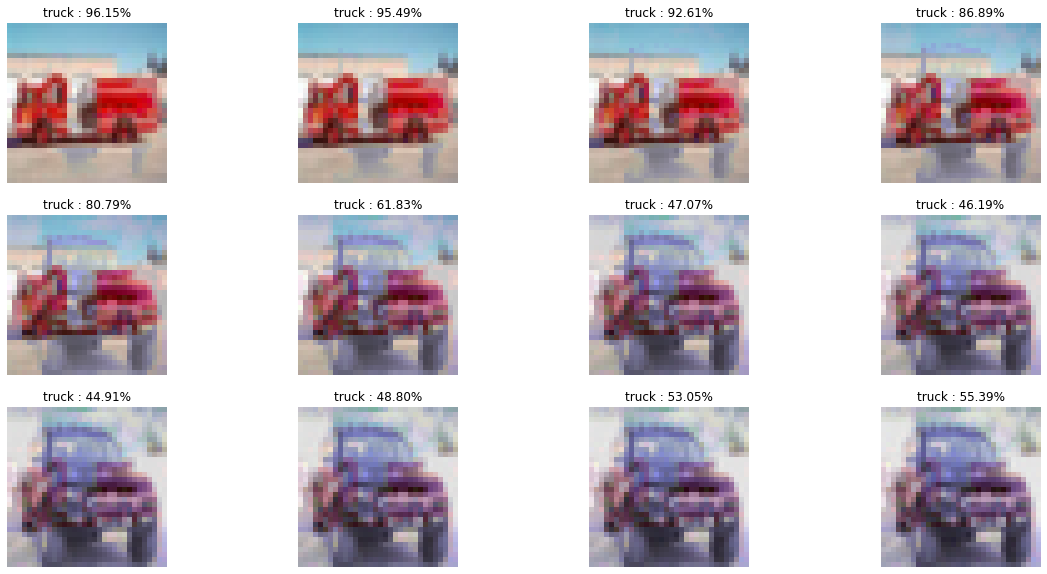

In [ ]:
# Plot the image during the algorithm
i = 0
fig,ax = plt.subplots(3,4)
step = len(l_x)//12
cpt = 0
for i in range(3):
  for j in range(4):
    ax[i,j].imshow(np.reshape(l_x[cpt],(32,32,3)))
    ax[i,j].set_axis_off()
    ax[i,j].set_xticklabels([])
    ax[i,j].set_xticks([])
    ax[i,j].set_yticklabels([])
    ax[i,j].set_yticks([])
    ax[i,j].set_title(classes[y_adv]+' : {:.2f}%'.format(l_conf[cpt].numpy()*100))
    cpt = cpt + step
fig.savefig('partial',dpi = 300)

# Label Only Attack

In [ ]:
# Return rediction in the label only setting
def label_only_model(model,x,k):
  y = np.reshape(model(x),(-1))
  y_order = np.flip(np.sort(y))[0:k]
  y_list = []
  for i in range(k):
    label = int(np.where(y==y_order[i])[0][0])
    y_list.append(label)
  return np.array(y_list)


In [ ]:
# Compute R function from the balck-box attack paper (2018)
def R(k,model,x,y_adv):
  y_model = label_only_model(model,x,k)
  if y_adv in y_model:
    return k - np.where(y_model == y_adv)[0][0]
  else:
    return 0

In [ ]:
# Compute an estimation of the prediction score
def proba_proxy(k,model,x,y_adv,mu,m):
  S = 0
  for i in range(m):
    delta = np.random.rand(1,32,32,3)*2-1
    S += R(k,model,x+mu*delta,y_adv)
  return S/m

In [ ]:
# NES Gradient Estimate in the label only setting
def label_only_nes(model,x,y,n_samples,sigma,N=32):
  if y in label_only_model(model,x,k):
    g = np.zeros((1,N,N,3))
    for i in range(n_samples):
      u = np.random.randn(1,N,N,3)
      g = g + proba_proxy(k,model,x + sigma*u,y,mu,m)*u
      g = g - proba_proxy(k,model,x - sigma*u,y,mu,m)*u
    return 1/(2*sigma*n_samples)*g 
  else:
    return 0

In [ ]:
# Attack in the label only setting
def label_only_attack(k,model,input_image, y_adv,eps_adv,eps_0,delta_eps,eta_max,eta_min,mu,m):
  cpt = 0
  eps = eps_0
  l_start = [i for i in range(len(y_test)) if np.argmax(y_test[i])==y_adv]
  x_adv = tf.constant(np.reshape(x_test[l_start[np.random.randint(len(l_start))]],(1,32,32,3)))
  x_adv = tf.clip_by_value(x_adv, input_image-eps, input_image+eps)
  while np.argmax(model1(x_adv)) != y_adv:
    x_adv = tf.constant(np.reshape(x_test[l_start[np.random.randint(len(l_start))]],(1,32,32,3)))
    x_adv = tf.clip_by_value(x_adv, input_image-eps, input_image+eps)
  x_adv = tf.clip_by_value(x_adv, input_image-eps, input_image+eps)
  l_x = [x_adv]
  while eps>eps_adv or np.argmax(model(x_adv)) != y_adv:
    print('confidence :'+str(model1(x_adv)[0][y_adv])+'   eps : '+str(eps))
    g = label_only_nes(model,x_adv,y_adv,n_samples,sigma)
    cpt += n_samples
    eta = eta_max
    x_adv_hat = tf.clip_by_value(x_adv + eta*g, input_image-eps, input_image+eps)
    while not(y_adv == label_only_model(model,x_adv_hat,k)[0]):
      if eta < eta_min:
        eps += 2*delta_eps
        delta_eps /= 2
        x_adv_hat = x_adv
        break
      eta /= 2
      x_adv_hat = tf.clip_by_value(x_adv + eta*g, input_image-eps, input_image+eps)
    x_adv = x_adv_hat
    eps -= delta_eps
    l_x.append(x_adv)
  print(cpt)
  return x_adv,l_x

confidence :tf.Tensor(0.9298678, shape=(), dtype=float32)   eps : 0.5098039215686274
confidence :tf.Tensor(0.9298678, shape=(), dtype=float32)   eps : 0.4998039215686274
confidence :tf.Tensor(0.9263224, shape=(), dtype=float32)   eps : 0.4898039215686274
confidence :tf.Tensor(0.9220496, shape=(), dtype=float32)   eps : 0.4798039215686274
confidence :tf.Tensor(0.91552526, shape=(), dtype=float32)   eps : 0.4698039215686274
confidence :tf.Tensor(0.9077894, shape=(), dtype=float32)   eps : 0.45980392156862737
confidence :tf.Tensor(0.89978206, shape=(), dtype=float32)   eps : 0.44980392156862736
confidence :tf.Tensor(0.8912377, shape=(), dtype=float32)   eps : 0.43980392156862735
confidence :tf.Tensor(0.8796886, shape=(), dtype=float32)   eps : 0.42980392156862735
confidence :tf.Tensor(0.8667635, shape=(), dtype=float32)   eps : 0.41980392156862734
confidence :tf.Tensor(0.8543505, shape=(), dtype=float32)   eps : 0.4098039215686273
confidence :tf.Tensor(0.83922184, shape=(), dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10920


Text(0.5, 1.0, 'dog')

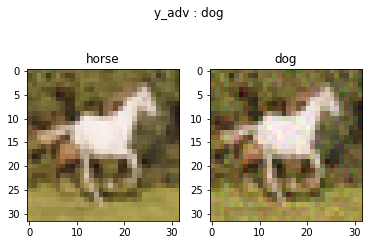

In [ ]:
### Parameters

# Data
n = np.random.randint(len(x_test))
x_natural = tf.constant([x_test[n]]) 
y_adv = 5

# PGD
epsilon = 13/255
alpha = 0.01
nb_iter = 20

# NES
sigma = 0.001
n_samples = 40

# Label Only attack
k = 1
eps_0 = 10*epsilon
delta_eps = 0.01
eta_max = 0.01
eta_min = 0.000000001
mu = 0.001
m = 20


### Attack

x_adv,l_x = label_only_attack(k,model1,x_natural, y_adv,epsilon,eps_0,delta_eps,eta_max,eta_min,mu,m)


fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle('y_adv : '+classes[y_adv])
ax1.imshow(x_test[n])
ax1.set_title(classes[np.argmax(y_test[n])])

ax2.imshow(np.reshape(x_adv,(32,32,3)))
ax2.set_title(classes[np.argmax(model1(x_adv))])




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


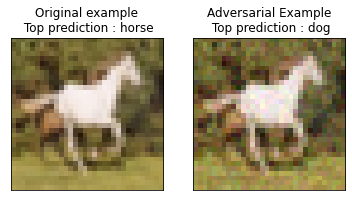

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(x_test[n])
ax1.set_title('Original example\n Top prediction : '+classes[np.argmax(y_test[n])])
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticklabels([])
ax1.set_yticks([])
ax2.imshow(np.reshape(x_adv,(32,32,3)))
ax2.set_title('Adversarial Example\n Top prediction : '+classes[np.argmax(model1(x_adv))])
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticklabels([])
ax2.set_yticks([])
plt.savefig('label_only',dpi = 300)